In [2]:
#importing necessary libraries

In [42]:
import itertools

import numpy as np
from random import gauss, shuffle 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans

import os


from  datetime import datetime, timedelta
import gc, copy

from gensim.models import Word2Vec
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from lightgbm import LGBMRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [3]:
# link to the dataset: 
# https://herts365-my.sharepoint.com/:x:/r/personal/sm22acy_herts_ac_uk/Documents/MSc_Project_21078559/HOBBIES_1_018_CA_1_validation.xlsx?d=wbeb7d8a6f67a4204a13c67694ae36fcd&csf=1&web=1&e=ECGsP1

In [43]:
sales_data = pd.read_excel('HOBBIES_1_018_CA_1_validation.xlsx')

sales_data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# the reduce_mem_usage function which iterates through each feature and 
# checks which features fall into which integer and floating data type bands.
# for example, if feature x requires just int 16 but it has been assigned int 32. 
# Then the function, converts the int 32 into int 16 thus saving memory and computational resources 

In [44]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type =='category': 
            df[col] = df[col].astype('category').cat.as_ordered()
            #faced an error where you cannot calculate the max and min value that an category can take
        
        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


sales_data = reduce_mem_usage(sales_data)

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.00 MB
Decreased by 86.5%


In [5]:
# data preprocessing

In [45]:
data = pd.melt(sales_data, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales')

In [46]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0
2,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0
3,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0
4,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0


In [6]:
# plotting the sales data

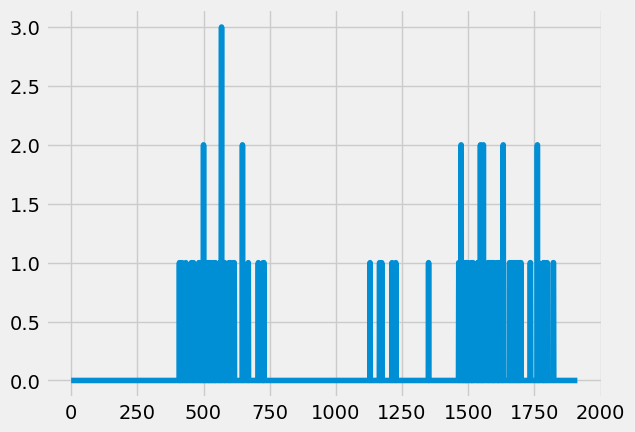

In [47]:
plt.plot(data['sales'])

In [ ]:
# merging the calender data
# link to calender data: https://herts365-my.sharepoint.com/:x:/r/personal/sm22acy_herts_ac_uk/Documents/MSc_Project_21078559/calendar.csv?d=w7154d49e66f74fb0a2c8cf712803a38e&csf=1&web=1&e=IxtJmi

In [48]:
xcal = pd.read_csv('calendar.csv')
xcal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [49]:
data = pd.merge(data, xcal, on='d', how='left')
del xcal

In [50]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


In [51]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.index.freq = 'D'

In [52]:
data.shape

(1913, 20)

In [53]:
#data['event_name_1'].value_counts()

In [54]:
#data['event_type_1'].value_counts()

In [55]:
data_encoded = pd.get_dummies(data, columns=['event_name_1','event_type_1','event_name_2','event_type_2'])

In [56]:
data_encoded.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,weekday,...,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,11101,Saturday,...,False,False,False,False,False,False,False,False,False,False
2011-01-30,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,11101,Sunday,...,False,False,False,False,False,False,False,False,False,False
2011-01-31,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,11101,Monday,...,False,False,False,False,False,False,False,False,False,False
2011-02-01,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,11101,Tuesday,...,False,False,False,False,False,False,False,False,False,False
2011-02-02,HOBBIES_1_018_CA_1_validation,HOBBIES_1_018,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,11101,Wednesday,...,False,False,False,False,False,False,False,False,False,False


In [57]:
data = data_encoded.drop(['id','item_id','dept_id','cat_id','store_id','state_id','wm_yr_wk','weekday'], axis=1)

In [58]:
data = data.drop(['d','wday','month'], axis=1)

In [59]:
data.head()

,sales,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,...,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-01-30,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-01-31,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-02-01,0,2011,1,1,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-02-02,0,2011,1,0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [60]:
data.fillna(-1)

,sales,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,...,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-01-30,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-01-31,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-02-01,0,2011,1,1,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2011-02-02,0,2011,1,0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,0,2016,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-04-21,0,2016,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2016-04-22,0,2016,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [61]:
data.shape

(1913, 45)

In [7]:
# creating lag features and rolling window features

In [62]:
#creating feature
# 7 days lag

freq = "28d"
data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

#freq = "30d"
#data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

#freq = "180d"
#data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

#freq = "365d"
#data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)

#freq = "730d"
#data[f"y_lag_{freq}"] = data["sales"].shift(freq=freq)


data.head()


,sales,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,...,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious,y_lag_28d
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
2011-01-30,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
2011-01-31,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
2011-02-01,0,2011,1,1,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN
2011-02-02,0,2011,1,0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,NaN


In [63]:
result = (
    data["sales"]
    .rolling(window=7) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1D") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_7_")

# add features to main dataframe

data = data.merge(result, how="left", left_index=True, right_index=True)

data.head()

,sales,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,...,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious,y_lag_28d,y_window_7_mean,y_window_7_std
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaN,NaN
2011-01-30,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaN,NaN
2011-01-31,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaN,NaN
2011-02-01,0,2011,1,1,0,False,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaN,NaN
2011-02-02,0,2011,1,0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,NaN,NaN,NaN


In [64]:
result = (
    data["sales"]
    .rolling(window=28) # Pick window size.
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1D") # Lag by 1 hour to avoid data leakage.
)  

result = result.add_prefix("y_window_28_")

# add features to main dataframe
data = data.merge(result, how="left", left_index=True, right_index=True)

data.head()

,sales,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,...,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious,y_lag_28d,y_window_7_mean,y_window_7_std,y_window_28_mean,y_window_28_std
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2011-01-30,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2011-01-31,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2011-02-01,0,2011,1,1,0,False,False,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN
2011-02-02,0,2011,1,0,1,False,False,False,False,False,...,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN


In [65]:
data["month"] = data.index.month
data["day"] = data.index.dayofweek

In [66]:
data.head()

,sales,year,snap_CA,snap_TX,snap_WI,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,...,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious,y_lag_28d,y_window_7_mean,y_window_7_std,y_window_28_mean,y_window_28_std,month,day
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,1,5
2011-01-30,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,1,6
2011-01-31,0,2011,0,0,0,False,False,False,False,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,1,0
2011-02-01,0,2011,1,1,0,False,False,False,False,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,2,1
2011-02-02,0,2011,1,0,1,False,False,False,False,False,...,False,False,False,NaN,NaN,NaN,NaN,NaN,2,2


In [67]:
#finalise tabulaisation

end_train_date = datetime(2011, 1, 29) + timedelta(days=1421)
end_validation_date = end_train_date + timedelta(days=265)

# Split the data
data_train = data.loc[:end_train_date]
data_val = data.loc[end_train_date + timedelta(days=1):end_validation_date]
data_test = data.loc[end_validation_date + timedelta(days=1):]

In [68]:
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validation : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-29 00:00:00 --- 2014-12-20 00:00:00  (n=1422)
Dates validation : 2014-12-21 00:00:00 --- 2015-09-11 00:00:00  (n=265)
Dates test       : 2015-09-12 00:00:00 --- 2016-04-24 00:00:00  (n=226)


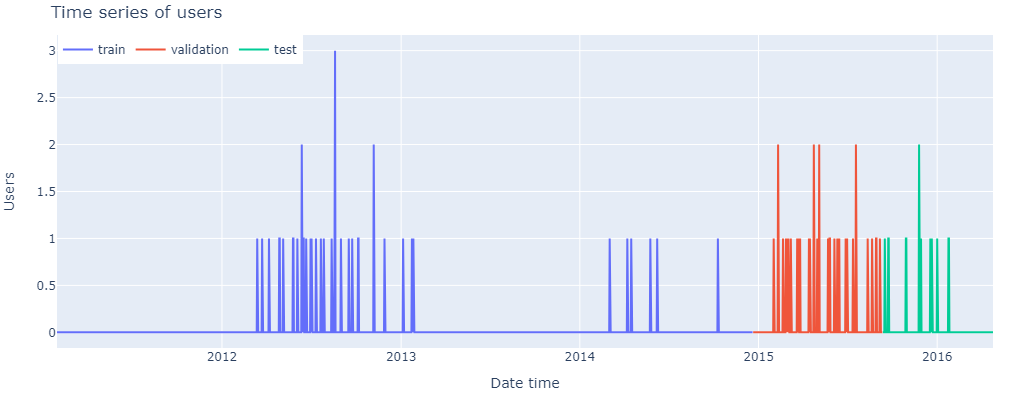

In [69]:
fig = go.Figure()
trace1 = go.Scatter(x=data_train.index, y=data_train['sales'], name="train", mode="lines")
trace2 = go.Scatter(x=data_val.index, y=data_val['sales'], name="validation", mode="lines")
trace3 = go.Scatter(x=data_test.index, y=data_test['sales'], name="test", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.add_trace(trace3)
fig.update_layout(
    title="Time series of users",
    xaxis_title="Date time",
    yaxis_title="Users",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

In [70]:
data.columns

Index(['sales', 'year', 'snap_CA', 'snap_TX', 'snap_WI',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_SuperBowl', 'event_name_1_Thanksgiving',
       'event_name_1_ValentinesDay', 'event_name_1

In [71]:
forecaster = ForecasterAutoreg(
    regressor=LGBMRegressor(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=300,
        num_leaves=40,
         objective = "tweedie",# Set num_leaves to be greater than 2^max_depth
        random_state=123,
        force_row_wise=True,
        # or force_col_wise=True if memory is a concern
    ),
    lags=24,
    
)

In [72]:
initial_train_size = len(data_train) + len(data_val)  # Combined length of training and validation sets

print(initial_train_size)

1687


In [73]:
exog = data[['year', 'snap_CA', 'snap_TX', 'snap_WI',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father\'s day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother\'s day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_SuperBowl', 'event_name_1_Thanksgiving',
       'event_name_1_ValentinesDay', 'event_name_1_VeteransDay',
       'event_type_1_Cultural', 'event_type_1_National',
       'event_type_1_Religious', 'event_type_1_Sporting',
       'event_name_2_Cinco De Mayo', 'event_name_2_Easter',
       'event_name_2_Father\'s day', 'event_name_2_OrthodoxEaster',
       'event_type_2_Cultural', 'event_type_2_Religious', 'y_lag_28d',
       'y_window_7_mean', 'y_window_7_std', 'y_window_28_mean',
       'y_window_28_std', 'month', 'day']]

In [74]:
exog.dtypes

year                                  int64
snap_CA                               int64
snap_TX                               int64
snap_WI                               int64
event_name_1_Chanukah End              bool
event_name_1_Christmas                 bool
event_name_1_Cinco De Mayo             bool
event_name_1_ColumbusDay               bool
event_name_1_Easter                    bool
event_name_1_Eid al-Fitr               bool
event_name_1_EidAlAdha                 bool
event_name_1_Father's day              bool
event_name_1_Halloween                 bool
event_name_1_IndependenceDay           bool
event_name_1_LaborDay                  bool
event_name_1_LentStart                 bool
event_name_1_LentWeek2                 bool
event_name_1_MartinLutherKingDay       bool
event_name_1_MemorialDay               bool
event_name_1_Mother's day              bool
event_name_1_NBAFinalsEnd              bool
event_name_1_NBAFinalsStart            bool
event_name_1_NewYear            

In [75]:
for col in exog.select_dtypes(include=['bool']).columns:
    exog.loc[:, col] = exog.loc[:, col].astype('int')

In [76]:
exog.columns = exog.columns.str.replace(' ', '')

In [77]:
#exog.dtypes

In [78]:
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data['sales'],
    initial_train_size=initial_train_size,
    fixed_train_size=False,
    steps=10,
    refit=True,
    metric='mean_squared_error',
    verbose=True,
    exog = exog # Change to True for detailed information
)

print(f"Backtest error: {metric}")

[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 1663, number of used features: 38
[LightGBM] [Info] Start training from score -3.098890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

D:\Anaconda\lib\site-packages\skforecast\utils\utils.py:418: MissingValuesWarning:

`exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)



  0%|          | 0/23 [00:00<?, ?it/s]

Backtest error: 0.06848061012839263


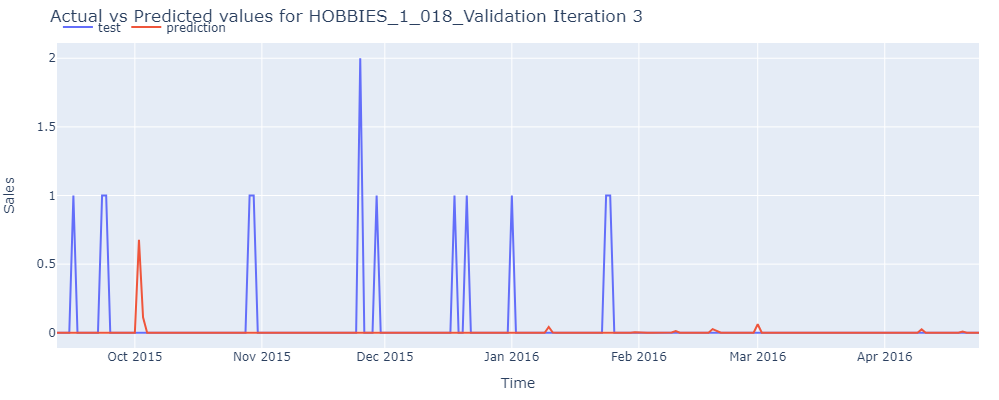

In [79]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['sales'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual vs Predicted values for HOBBIES_1_018_Validation Iteration 3",
    xaxis_title="Time",
    yaxis_title="Sales",
    width  = 800,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)
fig.show()
fig.write_image("actual_vs_predicted_HOBBIES_1_018_Validation_Iteration_3.png")

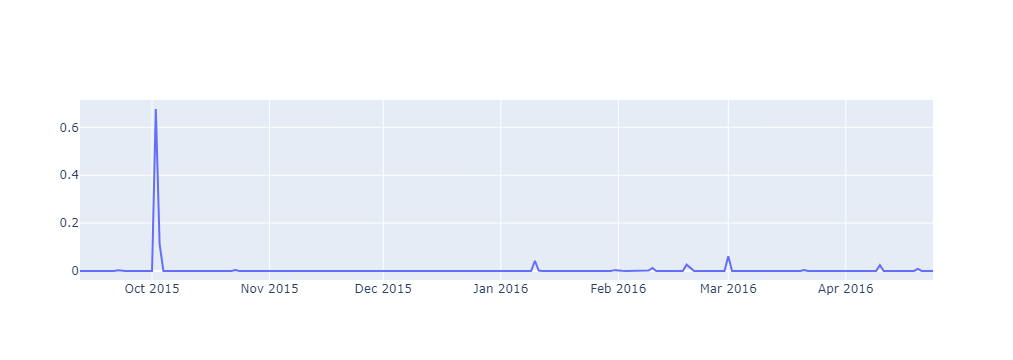

In [80]:
fig1 = go.Figure()
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig1.add_trace(trace2)

In [81]:
print(data_test['sales'])
print(np.round(predictions['pred'],2))

date
2015-09-12    0
2015-09-13    0
2015-09-14    0
2015-09-15    0
2015-09-16    1
             ..
2016-04-20    0
2016-04-21    0
2016-04-22    0
2016-04-23    0
2016-04-24    0
Freq: D, Name: sales, Length: 226, dtype: int8
2015-09-12    0.00
2015-09-13    0.00
2015-09-14    0.00
2015-09-15    0.00
2015-09-16    0.00
              ... 
2016-04-20    0.01
2016-04-21    0.00
2016-04-22    0.00
2016-04-23    0.00
2016-04-24    0.00
Freq: D, Name: pred, Length: 226, dtype: float64


def custom_metric(y_true = data_test['sales'], y_pred = np.round(predictions['pred'],2)):
    n = len(y_true)
    smape_values = []
    
    for i in range(n):
        if y_true[i] == 0 and y_pred[i] == 0:
            smape_values.append(0)
        else:
            denominator = (abs(y_true[i]) + abs(y_pred[i])) / 2
            numerator = abs(y_true[i] - y_pred[i])
            smape_values.append(numerator / denominator)
    
    return (100 / n) * sum(smape_values)

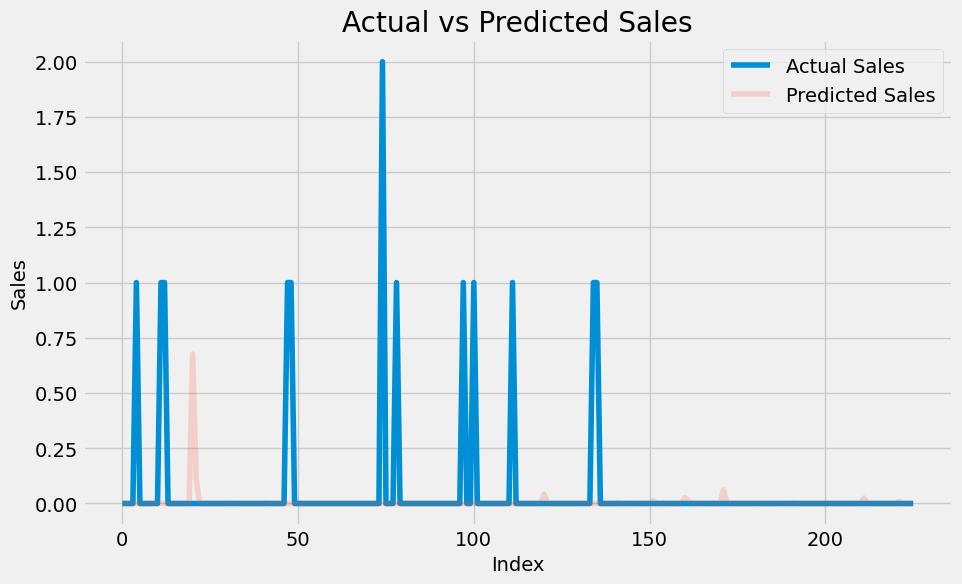

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(data_test['sales'].values, label='Actual Sales')
plt.plot(predictions['pred'].values, label='Predicted Sales', alpha = 0.2)
plt.xlabel('Index')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()